<a href="https://colab.research.google.com/github/alex-escobar-h/Facial-Expression-Recognition-Model/blob/main/facial_expression_recognition_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

## Set up Kaggle API

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

## Download and Unzip the FER-2013 Dataset from Kaggle

In [2]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Defining Image Size, Batch Size, and Dataset Path

In [3]:
img_size = 48
batch_size = 64
validation_split = 0.2

train_dir = "/content/train"
test_dir = "/content/test"

## Defining Transforms

In [4]:
import torch
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    # transforms.RandomRotation(15),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## Load Datasets and Create DataLoaders

In [5]:
from torch.utils.data import DataLoader, random_split

full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

total_train = len(full_train_dataset)
val_size = int(total_train * validation_split)
train_size = total_train - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = full_train_dataset.classes

## Visualizing the Training Image

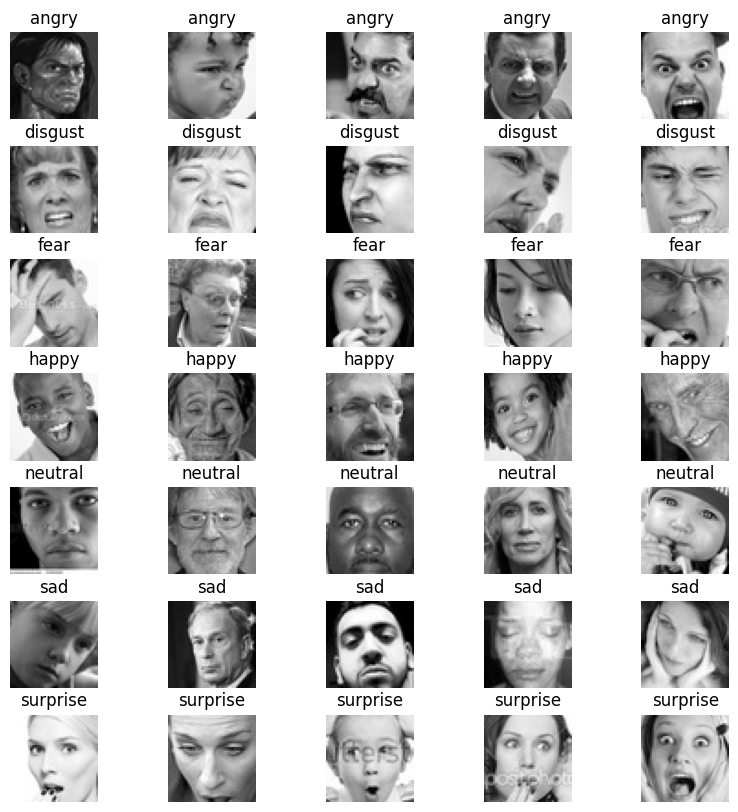

In [6]:
import matplotlib.pyplot as plt
import random

# Visualize training images
sample_num = 5
fig, axes = plt.subplots(nrows=len(classes), ncols=sample_num, figsize=(10,10))

for i, emotion in enumerate(classes):
    # Get all indices in train_dataset_full that belong to the current emotion
    indices = [idx for idx, (_, label) in enumerate(full_train_dataset.samples) if label == i]
    # Randomly sample indices for visualization
    sample_indices = random.sample(indices, sample_num)
    for j, idx in enumerate(sample_indices):
        img_path, _ = full_train_dataset.samples[idx]
        image = plt.imread(img_path)
        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_title(emotion)
        axes[i][j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

## CNN Model

In [7]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 48x48 -> 24x24
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),  # 24x24 -> 22x22
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),  # 22x22 -> 20x20
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20 -> 10x10
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),  # 10x10 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

## Initialize Device and Move Model to GPU (if available)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

CNN(
  (conv_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))


## Display Model Summary with Input Shape

In [9]:
from torchsummary import summary

summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]           9,248
       BatchNorm2d-5           [-1, 32, 48, 48]              64
              ReLU-6           [-1, 32, 48, 48]               0
         MaxPool2d-7           [-1, 32, 24, 24]               0
            Conv2d-8           [-1, 64, 22, 22]          18,496
       BatchNorm2d-9           [-1, 64, 22, 22]             128
             ReLU-10           [-1, 64, 22, 22]               0
           Conv2d-11           [-1, 64, 20, 20]          36,928
      BatchNorm2d-12           [-1, 64, 20, 20]             128
             ReLU-13           [-1, 64, 20, 20]               0
        MaxPool2d-14           [-1, 64,

## Define Loss Function and Optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Train and Validate the Model

In [11]:
n_epochs = 10
best_val_acc = 0.0

early_stop = 5
early_stop_counter = 0


for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch [{epoch}/{n_epochs}]")

    # ======== Training ========
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == target).sum().item()
        total_train += target.size(0)

    train_loss /= total_train
    train_acc = correct_train / total_train

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_val += (predicted == target).sum().item()
            total_val += target.size(0)

    val_loss /= total_val
    val_acc = correct_val / total_val

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter=0
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved.")
    else:
      early_stop_counter += 1

    # if early_stop_counter >= early_stop:
      # print("Early stop triggered")
      # break


Epoch [1/10]
Train Loss: 1.5644 | Train Acc: 0.3911
Val   Loss: 1.3493 | Val   Acc: 0.4907
Best model saved.

Epoch [2/10]
Train Loss: 1.3472 | Train Acc: 0.4837
Val   Loss: 1.3314 | Val   Acc: 0.4867

Epoch [3/10]
Train Loss: 1.2495 | Train Acc: 0.5234
Val   Loss: 1.2540 | Val   Acc: 0.5297
Best model saved.

Epoch [4/10]
Train Loss: 1.1800 | Train Acc: 0.5521
Val   Loss: 1.1969 | Val   Acc: 0.5544
Best model saved.

Epoch [5/10]
Train Loss: 1.1164 | Train Acc: 0.5788
Val   Loss: 1.1721 | Val   Acc: 0.5581
Best model saved.

Epoch [6/10]
Train Loss: 1.0583 | Train Acc: 0.6026
Val   Loss: 1.1625 | Val   Acc: 0.5555

Epoch [7/10]
Train Loss: 1.0024 | Train Acc: 0.6248
Val   Loss: 1.1540 | Val   Acc: 0.5673
Best model saved.

Epoch [8/10]
Train Loss: 0.9542 | Train Acc: 0.6442
Val   Loss: 1.1691 | Val   Acc: 0.5680
Best model saved.

Epoch [9/10]
Train Loss: 0.8854 | Train Acc: 0.6682
Val   Loss: 1.2756 | Val   Acc: 0.5574

Epoch [10/10]
Train Loss: 0.8267 | Train Acc: 0.6934
Val   Loss

## Test the Model

In [12]:
all_preds = []
all_labels = []
test_loss = 0.0
class_correct = [0 for i in range(len(classes))]
class_total = [0 for i in range(len(classes))]

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output, 1)
        correct = predicted.eq(target.view_as(predicted))

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
print(f"\nTest Loss: {test_loss:.6f}\n")

# Per-class accuracy
for i in range(len(classes)):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"Test Accuracy of {classes[i]:<10}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
    else:
        print(f"Test Accuracy of {classes[i]:<10}: N/A (no samples)")

# Overall accuracy
total_correct = sum(class_correct)
total_samples = sum(class_total)
overall_acc = 100 * total_correct / total_samples
print(f"\nTest Accuracy (Overall): {overall_acc:.2f}% ({int(total_correct)}/{int(total_samples)})")


Test Loss: 1.242041

Test Accuracy of angry     : 49.79% (477/958)
Test Accuracy of disgust   : 33.33% (37/111)
Test Accuracy of fear      : 27.83% (285/1024)
Test Accuracy of happy     : 77.68% (1378/1774)
Test Accuracy of neutral   : 53.28% (657/1233)
Test Accuracy of sad       : 63.99% (798/1247)
Test Accuracy of surprise  : 50.66% (421/831)

Test Accuracy (Overall): 56.46% (4053/7178)


## Confusion Matrix from Test Results

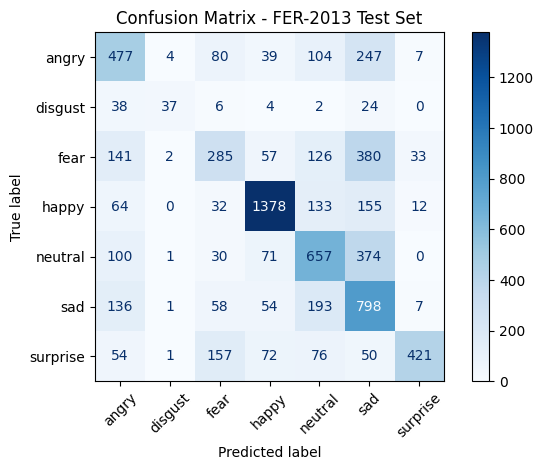

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - FER-2013 Test Set")
plt.tight_layout()
plt.show()